In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lifelines as lfl

In [8]:
colon = pd.read_csv('colon.csv')

In [44]:
colon

,time,status,rx,age,sex,age_high
0,8,1,3,32,0,0
1,9,1,3,55,1,0
2,19,1,1,59,1,0
3,20,1,2,66,1,1
4,23,0,3,52,0,0
...,...,...,...,...,...,...
883,3238,0,3,64,0,1
884,3308,0,3,68,0,1
885,3309,0,3,52,1,0
886,3325,0,1,62,0,1


In [9]:
colon = colon[["time", "status", "rx", "age", "sex"]]

In [10]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
kmf.fit(durations=colon['time'], event_observed=colon['status'])

# Raw event table
event_table = kmf.event_table.reset_index().rename(
    columns={'event_at': 'time',
             'removed': 'at_risk',
             'observed': 'events',
             'censored': 'censored'}
)
print(event_table.head(10))


   time  at_risk  events  censored  entrance  at_risk
0   0.0        0       0         0       888      888
1   8.0        1       1         0         0      888
2   9.0        1       1         0         0      887
3  19.0        1       1         0         0      886
4  20.0        1       1         0         0      885
5  23.0        1       0         1         0      884
6  24.0        1       0         1         0      883
7  28.0        1       1         0         0      882
8  35.0        1       1         0         0      881
9  36.0        1       1         0         0      880


In [11]:

T = colon['time']
E = colon['status']

# 2. Define fixed intervals, e.g. 0–30, 30–60, … up to max time
max_time = int(T.max())
interval_width = 30
breaks = np.arange(0, max_time + interval_width, interval_width)

# 3. Build the life table
rows = []
for start, stop in zip(breaks[:-1], breaks[1:]):
    # people who enter the interval
    at_risk = ((T >= start) & (T < stop)).sum() + (T >= stop).sum()
    # events in [start, stop)
    events = ((T >= start) & (T < stop) & (E == 1)).sum()
    # censored in [start, stop)
    censored = ((T >= start) & (T < stop) & (E == 0)).sum()
    rows.append({
        'interval_start': start,
        'interval_end': stop,
        'at_risk': at_risk,
        'events': events,
        'censored': censored
    })

life_table = pd.DataFrame(rows)
print(life_table)


     interval_start  interval_end  at_risk  events  censored
0                 0            30      888       5         2
1                30            60      881       8         2
2                60            90      871      18         0
3                90           120      853      24         0
4               120           150      829      14         0
..              ...           ...      ...     ...       ...
106            3180          3210        7       0         2
107            3210          3240        5       0         1
108            3240          3270        4       0         0
109            3270          3300        4       0         0
110            3300          3330        4       0         4

[111 rows x 5 columns]


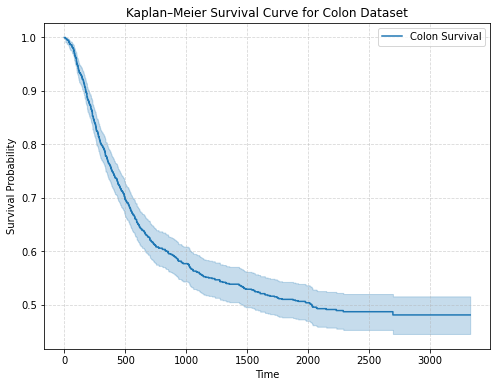

In [12]:
kmf = KaplanMeierFitter()
kmf.fit(durations=T, event_observed=E, label='Colon Survival')

# 3. Plot survival function
plt.figure(figsize=(8, 6))
kmf.plot_survival_function(ci_show=True)
plt.title('Kaplan–Meier Survival Curve for Colon Dataset')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [13]:
# wybor zmiennych do modelu

from lifelines.statistics import logrank_test

colon['age_high'] = (colon['age'] > colon['age'].median()).astype(int)
ix_low  = colon['age_high'] == 0
ix_high = colon['age_high'] == 1

results = logrank_test(
    colon.loc[ix_low,  'time'], 
    colon.loc[ix_high, 'time'],
    event_observed_A=colon.loc[ix_low,  'status'],
    event_observed_B=colon.loc[ix_high, 'status']
)
print(f"p‑value = {results.p_value:.4f}")
print(results.summary)


p‑value = 0.7837
   test_statistic         p  -log2(p)
0         0.07532  0.783743  0.351548


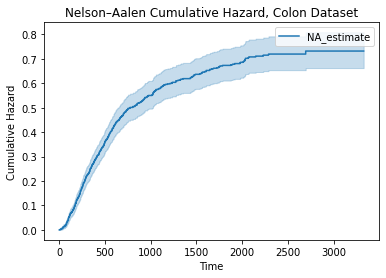

In [14]:
from lifelines import NelsonAalenFitter
import matplotlib.pyplot as plt

naf = NelsonAalenFitter()
naf.fit(durations=colon['time'], event_observed=colon['status'])

# Plot cumulative hazard
naf.plot_cumulative_hazard()
plt.title("Nelson–Aalen Cumulative Hazard, Colon Dataset")
plt.xlabel("Time")
plt.ylabel("Cumulative Hazard")
plt.show()


In [15]:
from lifelines import KaplanMeierFitter, WeibullFitter, ExponentialFitter, LogNormalFitter, LogLogisticFitter, GeneralizedGammaFitter, CoxPHFitter


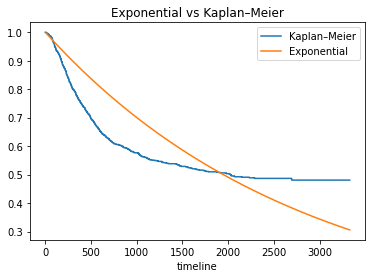

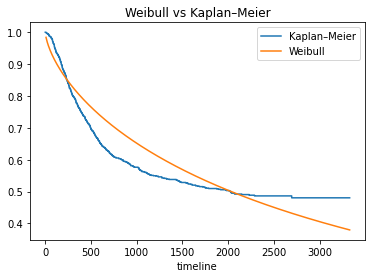

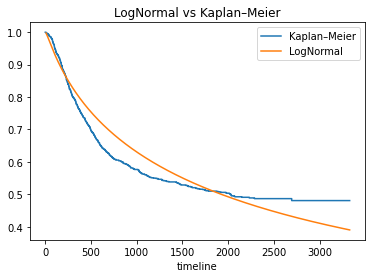

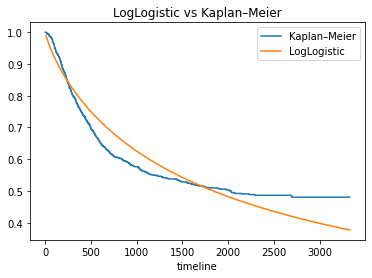

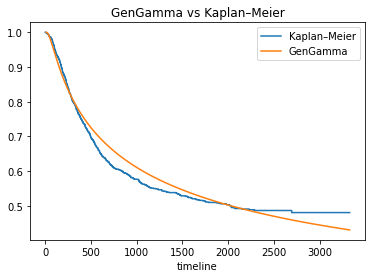


Exponential model summary:
                coef    se(coef)  coef lower 95%  coef upper 95%  cmp to  \
lambda_  2808.062893  132.965637     2547.455034     3068.670753     0.0   

                 z             p    -log2(p)  
lambda_  21.118711  5.353560e-99  326.450383  
AIC: 7976.703109306974

Weibull model summary:
                coef    se(coef)  coef lower 95%  coef upper 95%  cmp to  \
lambda_  3492.484145  268.030588     2967.153845     4017.814444     1.0   
rho_        0.678398    0.028714        0.622119        0.734676     1.0   

                 z             p    -log2(p)  
lambda_  13.026439  8.655362e-39  126.441601  
rho_    -11.200214  4.067477e-29   94.311780  
AIC: 7880.279620928219

LogNormal model summary:
            coef  se(coef)  coef lower 95%  coef upper 95%  cmp to          z  \
mu_     7.562233  0.080746        7.403974        7.720492     0.0  93.654667   
sigma_  1.963160  0.074056        1.818013        2.108307     1.0  13.005852   

               

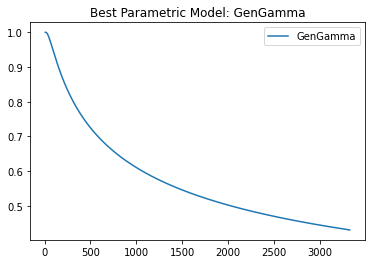

In [16]:
models = {
    'Exponential': ExponentialFitter(),
    'Weibull': WeibullFitter(),
    'LogNormal': LogNormalFitter(),
    'LogLogistic': LogLogisticFitter(),
    'GenGamma': GeneralizedGammaFitter()
}

# Fit models and collect AICs
aic_values = {}
for name, model in models.items():
    model.fit(colon['time'], colon['status'], label=name)
    aic_values[name] = model.AIC_

# Plot each model's survival function with Kaplan–Meier
for name, model in models.items():
    plt.figure()
    kmf.plot_survival_function(ci_show=False, label='Kaplan–Meier')
    model.plot_survival_function(ci_show=False, label=name)
    plt.title(f'{name} vs Kaplan–Meier')
    plt.legend()
    plt.show()

# Print model summaries and AICs
for name, model in models.items():
    print(f"\n{name} model summary:")
    print(model.summary)
    print(f"AIC: {model.AIC_}")

# Determine best model based on lowest AIC
best_model_name = min(aic_values, key=aic_values.get)
best_model = models[best_model_name]
print(f"\nBest model based on AIC: {best_model_name} (AIC={aic_values[best_model_name]})")

# Plot best model's survival function alone
plt.figure()
best_model.plot_survival_function(ci_show=False, label=best_model_name)
plt.title(f'Best Parametric Model: {best_model_name}')
plt.legend()
plt.show()

In [25]:
from lifelines import LogNormalAFTFitter

ln_aft = LogNormalAFTFitter()
ln_aft.fit(colon, duration_col='time', event_col='status')
print(ln_aft.summary)



                      coef   exp(coef)  se(coef)  coef lower 95%  \
param  covariate                                                   
mu_    age        0.020203    1.020408  0.009834        0.000929   
       age_high  -0.347452    0.706486  0.236100       -0.810200   
       rx         0.367670    1.444366  0.090239        0.190805   
       sex        0.221639    1.248120  0.144204       -0.060996   
       Intercept  5.676538  291.936958  0.547315        4.603820   
sigma_ Intercept  0.660762    1.936268  0.037660        0.586950   

                  coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  \
param  covariate                                                             
mu_    age              0.039477             1.000929             1.040267   
       age_high         0.115296             0.444769             1.122206   
       rx               0.544536             1.210223             1.723808   
       sex              0.504274             0.940827            

In [26]:
print(ln_aft.median_survival_time_)
print(ln_aft.mean_survival_time_)

2606.843477357909
16991.394002333258


<Axes: xlabel='log(accelerated failure rate) (95% CI)'>

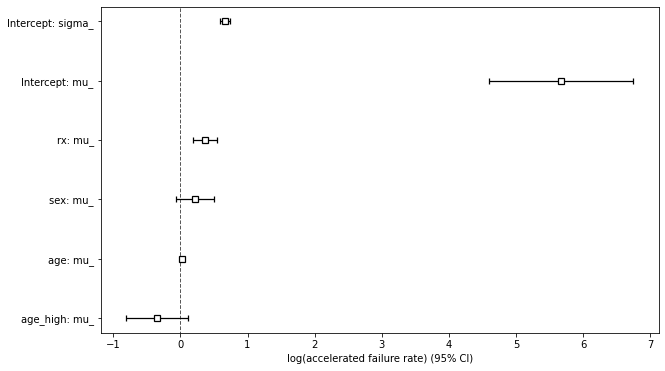

In [27]:
plt.subplots(figsize=(10, 6))
ln_aft.plot()

<Axes: >

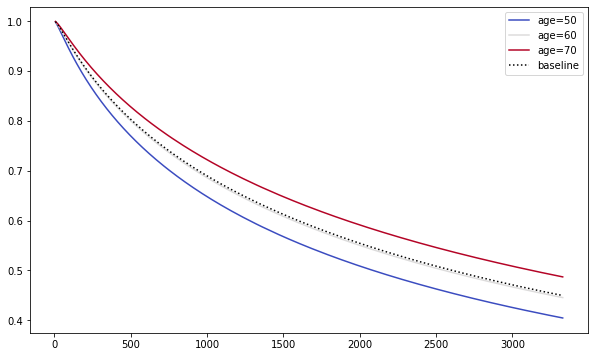

In [29]:
plt.subplots(figsize=(10, 6))
ln_aft.plot_partial_effects_on_outcome('age', range(50, 80, 10), cmap='coolwarm')

<Axes: >

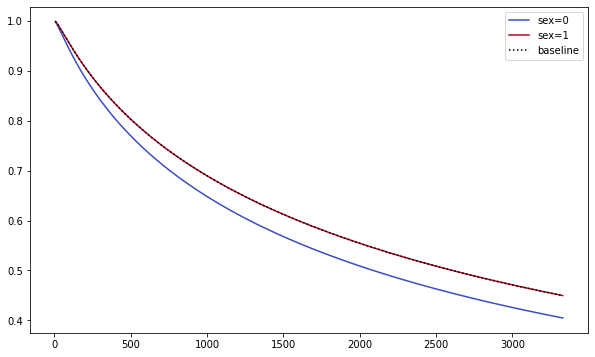

In [36]:
plt.subplots(figsize=(10, 6))
ln_aft.plot_partial_effects_on_outcome('sex',(0,1),cmap='coolwarm')

<Axes: >

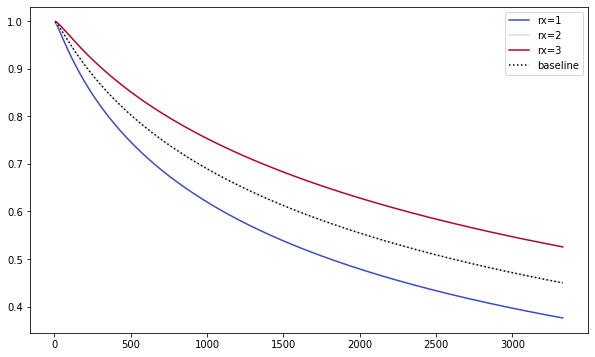

In [37]:
plt.subplots(figsize=(10, 6))
ln_aft.plot_partial_effects_on_outcome('rx',(1,2,3),cmap='coolwarm')

ICI =  0.010905264012089896
E50 =  0.009611060021754936


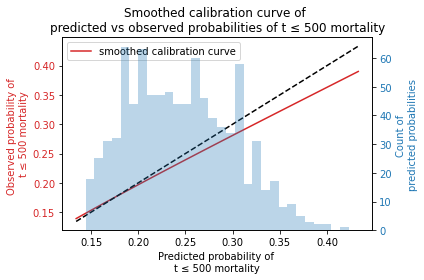

In [63]:
from lifelines.calibration import survival_probability_calibration
plt.figure()
survival_probability_calibration(model=ln_aft, df=colon, t0=500)
plt.show()
# ICI (Integrated Calibration Index)
# To średnia różnica między przewidywanym a rzeczywistym prawdopodobieństwem przeżycia:
# Im mniejsza, tym lepsza kalibracja (blisko 0 → dobrze skalibrowany model)
# E50 (Median Error)
# To mediana różnic między przewidywanym a obserwowanym prawdopodobieństwem przeżycia (dla danego horyzontu czasowego).
# Mierzy przeciętny błąd predykcji dla pojedynczych pacjentów.
# Ma taką samą interpretację jak ICI — im mniejsze, tym lepiej.


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


<lifelines.CoxPHFitter: fitted with 888 total observations, 442 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 888
number of events observed = 446
   partial log-likelihood = -2866.31
         time fit was run = 2025-05-18 20:10:04 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
rx        -0.23      0.80      0.06           -0.34           -0.12                0.71                0.89
age       -0.01      0.99      0.01           -0.03           -0.00                0.97                1.00
sex       -0.13      0.88      0.09           -0.32            0.05                0.73                1.05
age_high   0.25      1.29      0.16           -0.06            0.56                0.95                1.75

           cmp to     z      p  -log2(p)
covariate                               
rx           0.00 -3.94 <0.005     13.58
age          0.00 -2.18   0.03      5.09
sex          0.00 -1.41   0.16      2.65
age_high     0.00  1.60   0.11      3.20
---
Concordance = 0.57
Partial AIC = 5740.63
log-likelihood ratio test = 21.64 on 4 df
-log2(p) of ll-ratio test = 12.04

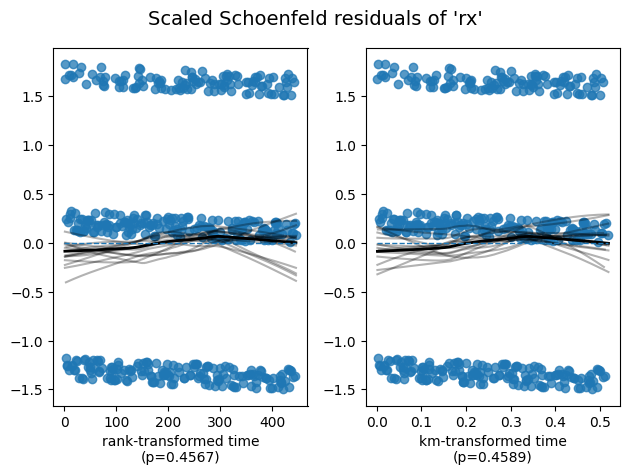

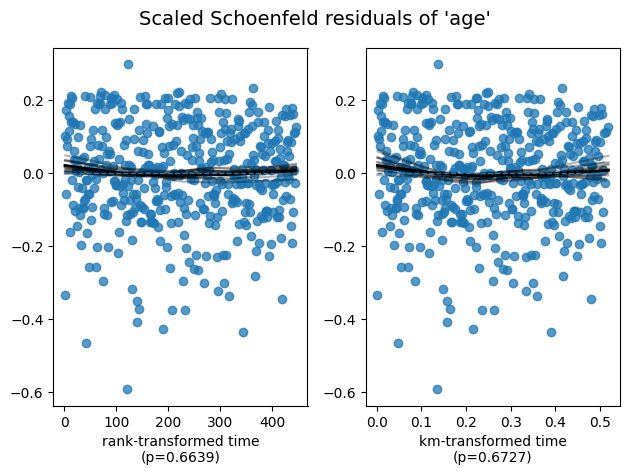

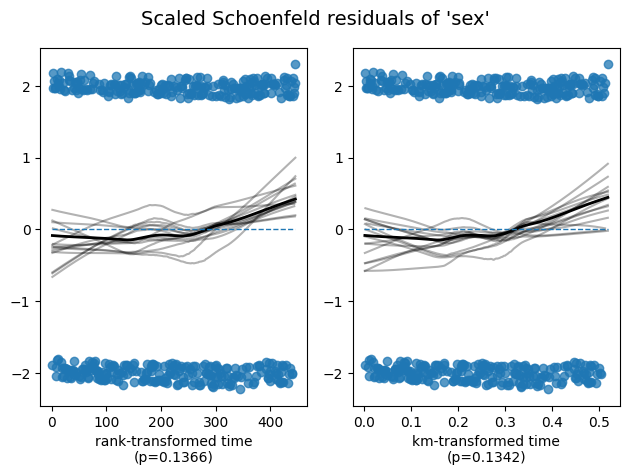

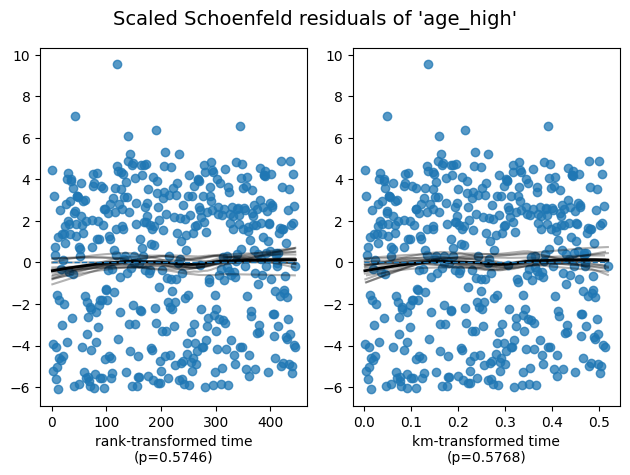

In [24]:
# 3. Semiparametric: Cox PH
cph = CoxPHFitter()
cph.fit(colon, 'time', 'status')
cph.check_assumptions(colon, p_value_threshold=0.05, show_plots=True)

cph.print_summary()

Interpreting the Schoenfeld residual plots in lifelines (from cph.check_assumptions(show_plots=True)) is crucial for assessing whether the proportional hazards (PH) assumption holds for each covariate in your Cox model.

What the Plots Show
Each plot represents:

X-axis: Time.

Y-axis: The scaled Schoenfeld residuals for a specific covariate.

Line: A smoothed curve through the residuals (often a LOESS or spline curve).

Shaded area: Confidence intervals for the smoothed line (if shown).

How to Interpret Them
✅ PH Assumption Holds (Good)
The smoothed curve is roughly flat (horizontal line at 0).

The residuals are randomly scattered around 0 with no clear trend over time.

The p-value is > 0.05, meaning no statistically significant time-dependence.

❌ PH Assumption Violated (Bad)
The smoothed line shows a trend over time (e.g., increasing or decreasing).

The residuals systematically drift upward or downward with time.

The p-value < 0.05, indicating that the effect of this variable changes over time.